# InfoGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='infoGAN') # Visdom

## MNIST Dataset

In [3]:
batch_size = 100
dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

## Define Model

In [4]:
# Feather Extractor
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1,64,4,2,1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 1024,7,bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self,x):
        output = self.main(x)
        return output

In [5]:
# Discriminator
class Dmodel(nn.Module):
    def __init__(self):
        super(Dmodel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1024,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        output=self.main(x).view(-1,1)
        return output

In [6]:
# Classifier Q
class Qmodel(nn.Module):
    def __init__(self):
        super(Qmodel,self).__init__()

        self.conv = nn.Conv2d(1024,128,1,bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = nn.Conv2d(128,10,1)
        self.conv_mu = nn.Conv2d(128,2,1)
        self.conv_var = nn.Conv2d(128,2,1)

    def forward(self,x):
        y = self.conv(x)
        disc_logits = self.conv_disc(y).squeeze()
        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()
        return disc_logits, mu, var

In [7]:
# Generator
class Gmodel(nn.Module):
    def __init__(self):
        super(Gmodel, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 1024,1,1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 128,7,1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,4,2,1,bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
# Models
FE=FrontEnd()
D=Dmodel()
Q=Qmodel()
G=Gmodel()

for i in [FE, D, Q, G]:
    i.cuda()
    i.apply(weights_init)

## Defin Losses & Optimizer

![log_gaussian](https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png)
https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png

In [9]:
# Define Losses
class log_gaussian:
    def __call__(self, x, mu, var):
        logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - (x-mu).pow(2).div(var.mul(2.0)+1e-6)
        return logli.sum(1).mean().mul(-1)

criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = log_gaussian()

In [10]:
# Optimizers
optimD = optim.Adam([{'params':FE.parameters()},
                     {'params':D.parameters()}],
                    lr=0.0002, betas=(0.5, 0.99))

optimG = optim.Adam([{'params':G.parameters()},
                     {'params':Q.parameters()}],
                    lr=0.001, betas=(0.5, 0.99))

## Define Inputs Codes

In [11]:
# fixed random variables for test
c0 = torch.linspace(-1,1,10).repeat(10).view(-1,1)
c1 = torch.cat((c0, torch.zeros(1).expand_as(c0)),1).cuda()
c2 = torch.cat((torch.zeros(1).expand_as(c0), c0),1).cuda()
one_hot = torch.eye(10).repeat(1,1,10).view(batch_size,10).cuda()
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1).cuda()


# random noises sampling function
def _noise_sample(dis_c, con_c, noise, bs):
    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0
    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
    return z, idx

## Training

Epoch:0, Iter:0, Dloss: 1.4174987077713013, Gloss: 3.2705907821655273, Preal: 0.5041512846946716, Pfake: 0.47320762276649475


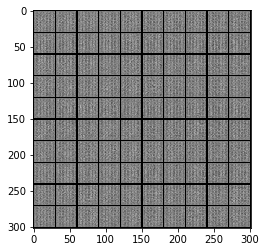

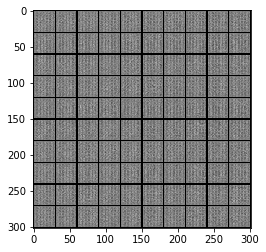

Epoch:0, Iter:200, Dloss: 0.775131344795227, Gloss: 1.6032506227493286, Preal: 0.6749230623245239, Pfake: 0.27199211716651917


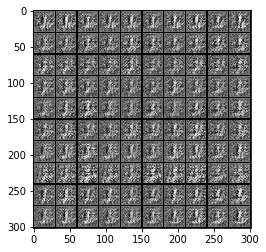

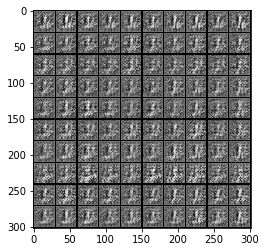

Epoch:0, Iter:400, Dloss: 1.1797237396240234, Gloss: 0.9388725757598877, Preal: 0.5775185823440552, Pfake: 0.4061555862426758


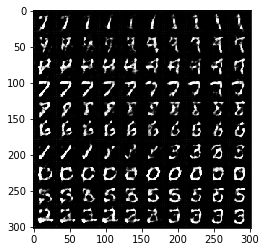

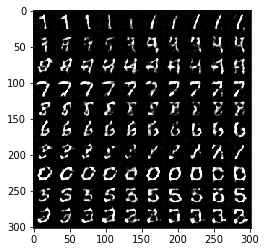

Epoch:1, Iter:0, Dloss: 1.1394329071044922, Gloss: 0.9522528052330017, Preal: 0.5692971348762512, Pfake: 0.38482338190078735


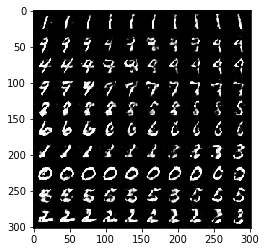

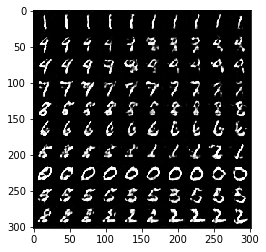

Epoch:1, Iter:200, Dloss: 1.1353256702423096, Gloss: 1.0064926147460938, Preal: 0.5690773129463196, Pfake: 0.3744007349014282


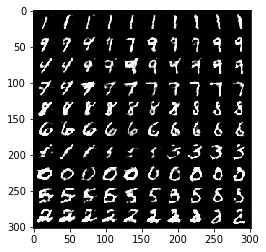

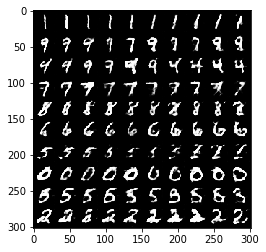

Epoch:1, Iter:400, Dloss: 1.1992714405059814, Gloss: 0.9384198784828186, Preal: 0.557896077632904, Pfake: 0.38871023058891296


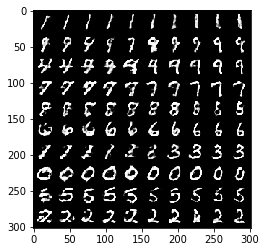

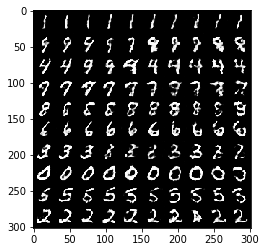

Epoch:2, Iter:0, Dloss: 1.1925170421600342, Gloss: 0.9979297518730164, Preal: 0.5628456473350525, Pfake: 0.3998807966709137


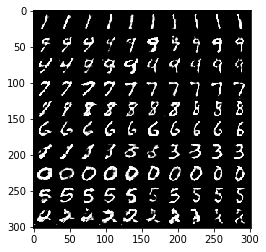

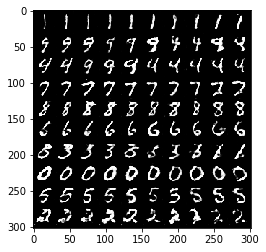

Epoch:2, Iter:200, Dloss: 1.2268974781036377, Gloss: 0.8607531785964966, Preal: 0.5592703223228455, Pfake: 0.40866243839263916


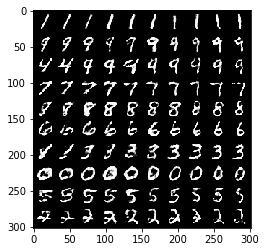

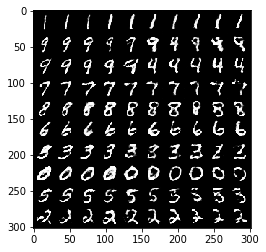

Epoch:2, Iter:400, Dloss: 1.225579023361206, Gloss: 0.9413114190101624, Preal: 0.5542963147163391, Pfake: 0.40067753195762634


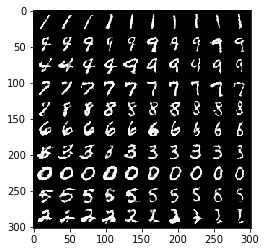

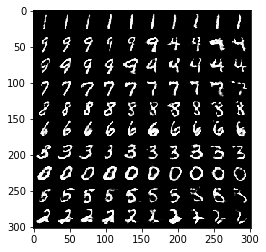

Epoch:3, Iter:0, Dloss: 1.2399437427520752, Gloss: 0.9012443423271179, Preal: 0.5569555759429932, Pfake: 0.40583908557891846


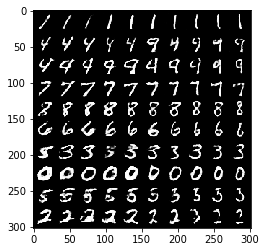

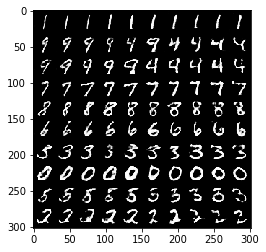

Epoch:3, Iter:200, Dloss: 1.2532451152801514, Gloss: 0.9425163865089417, Preal: 0.5532301664352417, Pfake: 0.4175480902194977


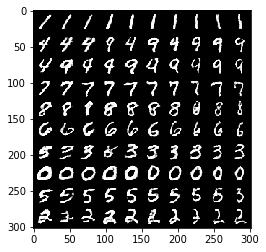

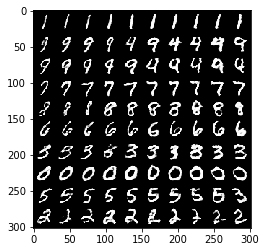

Epoch:3, Iter:400, Dloss: 1.2769496440887451, Gloss: 0.8627808094024658, Preal: 0.5361648201942444, Pfake: 0.4099273681640625


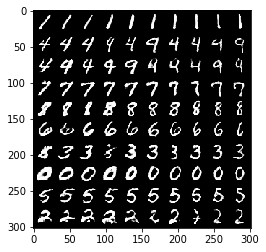

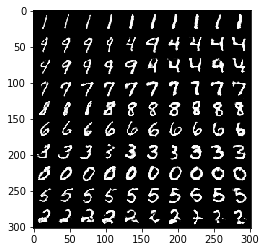

Epoch:4, Iter:0, Dloss: 1.1530593633651733, Gloss: 0.8942117094993591, Preal: 0.5908167362213135, Pfake: 0.39743080735206604


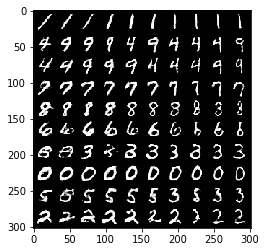

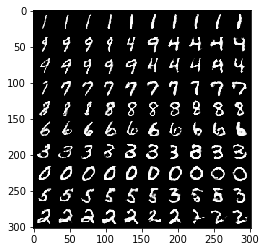

Epoch:4, Iter:200, Dloss: 1.2476465702056885, Gloss: 0.9209014177322388, Preal: 0.5532374978065491, Pfake: 0.39394283294677734


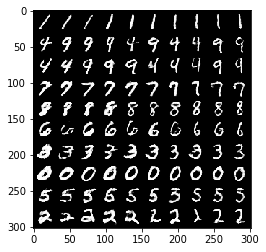

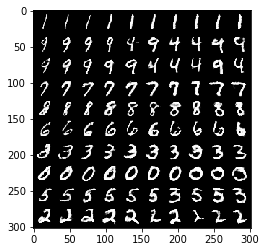

Epoch:4, Iter:400, Dloss: 1.1460654735565186, Gloss: 0.9631374478340149, Preal: 0.5892884731292725, Pfake: 0.393719881772995


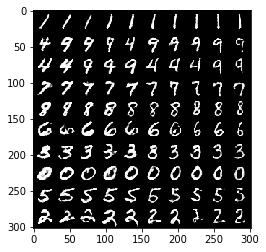

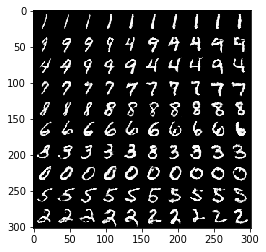

Epoch:5, Iter:0, Dloss: 1.2245676517486572, Gloss: 0.9228413105010986, Preal: 0.5755442976951599, Pfake: 0.3974446654319763


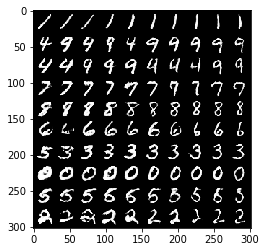

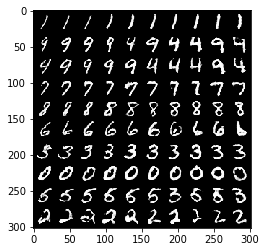

Epoch:5, Iter:200, Dloss: 1.2217063903808594, Gloss: 0.9166035056114197, Preal: 0.564564049243927, Pfake: 0.39538851380348206


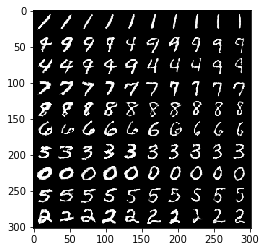

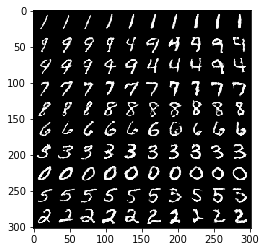

Epoch:5, Iter:400, Dloss: 1.264396071434021, Gloss: 0.9505966901779175, Preal: 0.5378096699714661, Pfake: 0.4040517210960388


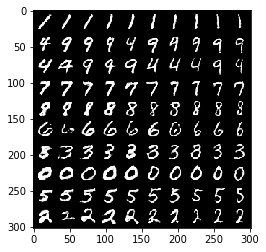

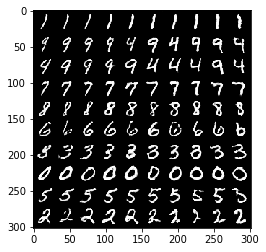

Epoch:6, Iter:0, Dloss: 1.209582805633545, Gloss: 0.8525770902633667, Preal: 0.587969183921814, Pfake: 0.4091928005218506


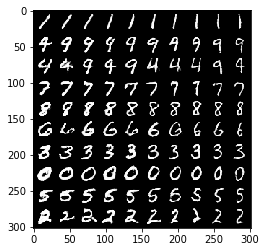

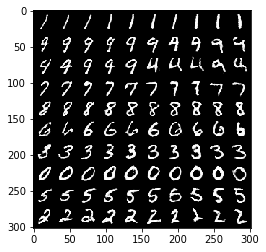

Epoch:6, Iter:200, Dloss: 1.186538577079773, Gloss: 0.9412603378295898, Preal: 0.5703643560409546, Pfake: 0.37932559847831726


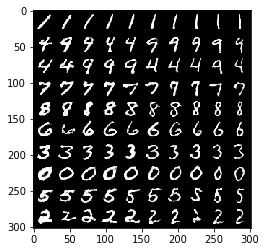

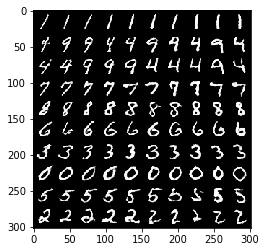

Epoch:6, Iter:400, Dloss: 1.234004259109497, Gloss: 0.8786588907241821, Preal: 0.5690204501152039, Pfake: 0.40231984853744507


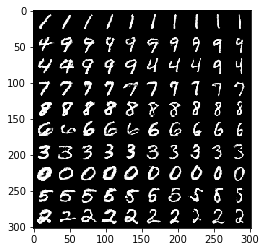

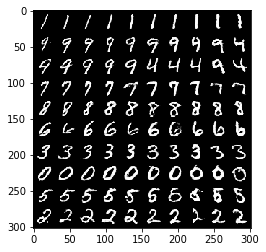

Epoch:7, Iter:0, Dloss: 1.1642723083496094, Gloss: 0.9064043164253235, Preal: 0.6171858310699463, Pfake: 0.3831627666950226


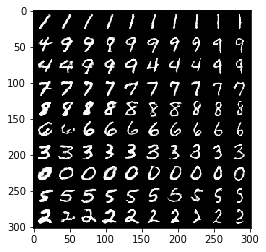

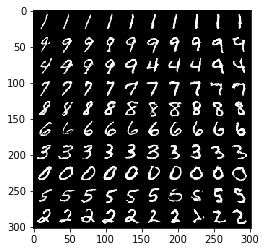

Epoch:7, Iter:200, Dloss: 1.182822823524475, Gloss: 0.9892563223838806, Preal: 0.5753254294395447, Pfake: 0.370985746383667


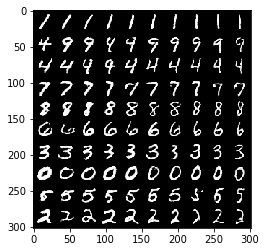

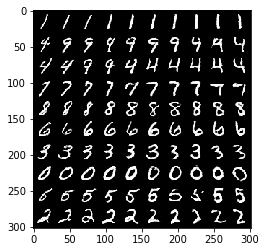

Epoch:7, Iter:400, Dloss: 1.2480894327163696, Gloss: 0.9269299507141113, Preal: 0.5298736691474915, Pfake: 0.3746950328350067


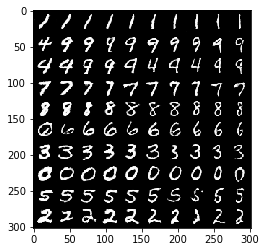

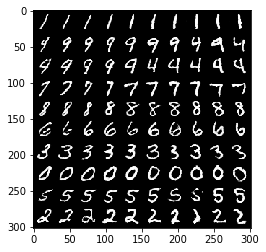

In [12]:
for epoch in range(8):
    for num_iters, batch_data in enumerate(dataloader,0):
        real_labels = torch.ones(batch_size,1).cuda()
        fake_labels = torch.zeros(batch_size,1).cuda()
        
        # Train Discriminator D and Feature Extractor FE
        # real part
        x, _ = batch_data
        real_x = x.cuda()

        fe_out1 = FE(real_x)
        probs_real = D(fe_out1)
        loss_real = criterionD(probs_real, real_labels)

        # fake part
        dis_c = torch.FloatTensor(batch_size,10).cuda()
        con_c = torch.FloatTensor(batch_size,2).cuda()
        noise = torch.FloatTensor(batch_size,62).cuda()
        z, idx = _noise_sample(dis_c,con_c,noise,batch_size)

        fake_x = G(z)
        fe_out2 = FE(fake_x.detach())
        probs_fake = D(fe_out2)
        loss_fake = criterionD(probs_fake, fake_labels)

        D_loss = loss_real + loss_fake
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()

        # Train Generator G and Clasifier Q (Lower bound of InfoMax Term)        
        fe_out = FE(fake_x)
        probs_fake = D(fe_out)
        G_loss = criterionD(probs_fake, real_labels)

        q_logits, q_mu, q_var = Q(fe_out)
        target_class = torch.LongTensor(idx).cuda()
        
        dis_loss = criterionQ_dis(q_logits, target_class)        
        con_loss = criterionQ_con(con_c, q_mu, q_var)*0.1
        
        G_loss_with_InfoMax = G_loss + dis_loss + con_loss
        
        optimG.zero_grad()
        G_loss_with_InfoMax.backward()
        optimG.step()

        if num_iters % 200 == 0:
            print('Epoch:{0}, Iter:{1}, Dloss: {2}, Gloss: {3}, Preal: {4}, Pfake: {5}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss_with_InfoMax.data.cpu().numpy(), probs_real.data.mean(), probs_fake.data.mean())
            )

            z = torch.cat([fix_noise, one_hot, c1], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            if not os.path.exists('infoGan_out/'):
                os.makedirs('infoGan_out/')
            
            title1 = '(C1)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title1+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title1,factor=1)
             
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()              
            
            z = torch.cat([fix_noise, one_hot, c2], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            title2 = '(C2)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title2+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title2,factor=1)
            
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  
    